### Content based anime recomender system TFIDF
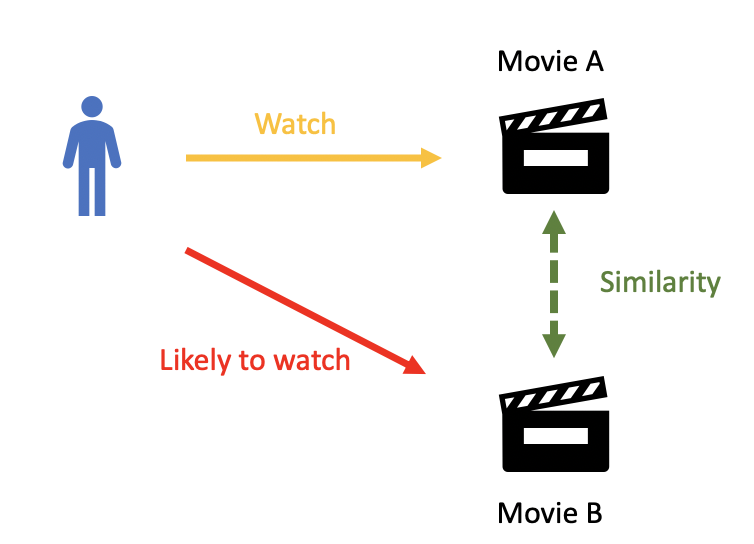

In [1]:
###### All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation
import nltk 
import os
#nltk.download("stopwords")

In [2]:
os.getcwd()

'C:\\Users\\jorge.grisman\\Documents\\recommendation_system_notebooks\\content-based'

In [3]:
####load dataset and replace "Unknown" cells with nan""
anime = pd.read_csv("data/anime.csv", na_values = ["Unknown"])

anime.columns = anime.columns.str.strip().str.lower().str.replace(' ', '_',regex=True).str.replace('(', '',regex=True).str.replace(')', '',regex=True)


synopsis = pd.read_csv("data/anime_with_synopsis.csv", na_values = ["Unknown"]) 

synopsis.columns = synopsis.columns.str.strip().str.lower().str.replace(' ', '_',regex=True).str.replace('(', '',regex=True).str.replace(')', '',regex=True)


In [4]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 50,'display.max_columns',50):
              display(anime.head(2))

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,producers,licensors,studios,source,duration,rating,ranked,popularity,members,favorites,watching,completed,on-hold,dropped,plan_to_watch,score-10,score-9,score-8,score-7,score-6,score-5,score-4,score-3,score-2,score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [5]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 50,'display.max_columns',50):
              display(synopsis.head(2))

,mal_id,name,score,genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [7]:
anime.columns

Index(['mal_id', 'name', 'score', 'genres', 'english_name', 'japanese_name',
       'type', 'episodes', 'aired', 'premiered', 'producers', 'licensors',
       'studios', 'source', 'duration', 'rating', 'ranked', 'popularity',
       'members', 'favorites', 'watching', 'completed', 'on-hold', 'dropped',
       'plan_to_watch', 'score-10', 'score-9', 'score-8', 'score-7', 'score-6',
       'score-5', 'score-4', 'score-3', 'score-2', 'score-1'],
      dtype='object')

In [8]:
synopsis.columns

Index(['mal_id', 'name', 'score', 'genres', 'sypnopsis'], dtype='object')

In [9]:
anime = anime.merge(synopsis, on = ['mal_id', "name", 'score', 'genres'])

In [11]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 20,'display.max_columns',50):
              display(anime.head(5))

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,producers,licensors,studios,source,duration,rating,ranked,popularity,members,favorites,watching,completed,on-hold,dropped,plan_to_watch,score-10,score-9,score-8,score-7,score-6,score-5,score-4,score-3,score-2,score-1,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventur...",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to A...",Spring 1998,Bandai Visual,"Funimation, Band...",Sunrise,Original,24 min. per ep.,R - 17+ (violenc...,28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,In the year 2071...
1,5,Cowboy Bebop: Te...,8.39,"Action, Drama, M...",Cowboy Bebop:The...,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,"Sunrise, Bandai ...",Sony Pictures En...,Bones,Original,1 hr. 55 min.,R - 17+ (violenc...,159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, anoth..."
2,6,Trigun,8.24,"Action, Sci-Fi, ...",Trigun,トライガン,TV,26.0,"Apr 1, 1998 to S...",Spring 1998,Victor Entertain...,"Funimation, Gene...",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13...,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,Vash the Stamped...
3,7,Witch Hunter Robin,7.27,"Action, Mystery,...",Witch Hunter Robin,Witch Hunter ROB...,TV,26.0,"Jul 2, 2002 to D...",Summer 2002,"TV Tokyo, Bandai...","Funimation, Band...",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13...,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,ches are individ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fanta...",Beet the Vandel ...,冒険王ビィト,TV,52.0,"Sep 30, 2004 to ...",Fall 2004,"TV Tokyo, Dentsu",NaN,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,It is the dark c...


In [12]:
anime.columns

Index(['mal_id', 'name', 'score', 'genres', 'english_name', 'japanese_name',
       'type', 'episodes', 'aired', 'premiered', 'producers', 'licensors',
       'studios', 'source', 'duration', 'rating', 'ranked', 'popularity',
       'members', 'favorites', 'watching', 'completed', 'on-hold', 'dropped',
       'plan_to_watch', 'score-10', 'score-9', 'score-8', 'score-7', 'score-6',
       'score-5', 'score-4', 'score-3', 'score-2', 'score-1', 'sypnopsis'],
      dtype='object')

In [13]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 16213
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mal_id         16214 non-null  int64  
 1   name           16214 non-null  object 
 2   score          11091 non-null  float64
 3   genres         16151 non-null  object 
 4   english_name   6593 non-null   object 
 5   japanese_name  16169 non-null  object 
 6   type           16177 non-null  object 
 7   episodes       15737 non-null  float64
 8   aired          15906 non-null  object 
 9   premiered      4745 non-null   object 
 10  producers      8756 non-null   object 
 11  licensors      3747 non-null   object 
 12  studios        10049 non-null  object 
 13  source         12896 non-null  object 
 14  duration       15663 non-null  object 
 15  rating         15526 non-null  object 
 16  ranked         15800 non-null  float64
 17  popularity     16214 non-null  int64  
 18  member

In [14]:
anime.fillna("", inplace = True)

In [18]:
def text_proc(words):
    no_punc = "".join([i for i in words if i not in punctuation])
    words = " ".join([w for w in no_punc.split() if w not in stopwords.words("english")])
    return words
def no_spaces(x):
    return x.replace(" ", "")

In [19]:
def unit_features(x):
    return " ".join([
        x["name"], text_proc(x["sypnopsis"]), 
        text_proc(x["genres"]),  x["type"], 
        no_spaces(x["studios"]), no_spaces(x["rating"])]) 

In [16]:

from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',60,'display.max_columns',50):
        display(anime[["name","sypnopsis","genres","type","studios","rating"]].head(10))

,name,sypnopsis,genres,type,studios,rating
0,Cowboy Bebop,"In the year 2071, humanity has colonized several of the ...","Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,Sunrise,R - 17+ (violence & profanity)
1,Cowboy Bebop: Tengoku no Tobira,"other day, another bounty—such is the life of the often ...","Action, Drama, Mystery, Sci-Fi, Space",Movie,Bones,R - 17+ (violence & profanity)
2,Trigun,"Vash the Stampede is the man with a $$60,000,000,000 bou...","Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,Madhouse,PG-13 - Teens 13 or older
3,Witch Hunter Robin,"ches are individuals with special powers like ESP, telek...","Action, Mystery, Police, Supernatural, Drama, Magic",TV,Sunrise,PG-13 - Teens 13 or older
4,Bouken Ou Beet,It is the dark century and the people are suffering unde...,"Adventure, Fantasy, Shounen, Supernatural",TV,Toei Animation,PG - Children
5,Eyeshield 21,Sena is like any other shy kid starting high school; he'...,"Action, Sports, Comedy, Shounen",TV,Gallop,PG-13 - Teens 13 or older
6,Hachimitsu to Clover,"Yuuta Takemoto, a sophomore at an arts college, shares a...","Comedy, Drama, Josei, Romance, Slice of Life",TV,J.C.Staff,PG-13 - Teens 13 or older
7,Hungry Heart: Wild Striker,Kyosuke Kano has lived under the shadow of his successfu...,"Slice of Life, Comedy, Sports, Shounen",TV,Nippon Animation,PG-13 - Teens 13 or older
8,Initial D Fourth Stage,Takumi Fujiwara finally joins Ryousuke and Keisuke Takah...,"Action, Cars, Sports, Drama, Seinen",TV,A.C.G.T.,PG-13 - Teens 13 or older
9,Monster,"Dr. Kenzou Tenma, an elite neurosurgeon recently engaged...","Drama, Horror, Mystery, Police, Psychological, Seinen, T...",TV,Madhouse,R+ - Mild Nudity


In [20]:
import time

start_time = time.time()

# create full column with all important info about anime
anime["full"] = anime.apply(unit_features, axis = 1)

print("--- %s seconds ---" % (time.time() - start_time))

--- 239.2384433746338 seconds ---


In [21]:
 239.238/60

3.9873

In [22]:
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth', 20,'display.max_columns',50):
              display(anime.head(2))

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,producers,licensors,studios,source,duration,rating,ranked,popularity,members,favorites,watching,completed,on-hold,dropped,plan_to_watch,score-10,score-9,score-8,score-7,score-6,score-5,score-4,score-3,score-2,score-1,sypnopsis,full
0,1,Cowboy Bebop,8.78,"Action, Adventur...",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to A...",Spring 1998,Bandai Visual,"Funimation, Band...",Sunrise,Original,24 min. per ep.,R - 17+ (violenc...,28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,In the year 2071...,Cowboy Bebop In ...
1,5,Cowboy Bebop: Te...,8.39,"Action, Drama, M...",Cowboy Bebop:The...,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",,"Sunrise, Bandai ...",Sony Pictures En...,Bones,Original,1 hr. 55 min.,R - 17+ (violenc...,159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,"other day, anoth...",Cowboy Bebop: Te...


In [23]:

from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',60,'display.max_columns',50):
        display(anime.full[2])

'Trigun Vash Stampede man 60000000000 bounty head The reason hes merciless villain lays waste oppose flattens entire cities fun garnering title The Humanoid Typhoon He leaves trail death destruction wherever goes anyone count dead much make eye contact—or rumors say In actuality Vash huge softie claims never taken life avoids violence costs With crazy doughnut obsession buffoonish attitude tow Vash traverses wasteland planet Gunsmoke followed two insurance agents Meryl Stryfe Milly Thompson attempt minimize impact public But soon misadventures evolve lifeordeath situations group legendary assassins summoned bring suffering trio Vashs agonizing past unraveled morality principles pushed breaking point Action SciFi Adventure Comedy Drama Shounen TV Madhouse PG-13-Teens13orolder'

In [26]:

from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',60,'display.max_columns',50):
        display(anime.iloc[100])
        
        
from pandas import option_context

with option_context('display.max_rows', None,'display.max_colwidth',60,'display.max_columns',50):
        display(anime.full[100])

mal_id                                                                   121
name                                                     Fullmetal Alchemist
score                                                                   8.17
genres           Action, Adventure, Comedy, Drama, Fantasy, Magic, Milita...
english_name                                             Fullmetal Alchemist
japanese_name                                                         鋼の錬金術師
type                                                                      TV
episodes                                                                51.0
aired                                             Oct 4, 2003 to Oct 2, 2004
premiered                                                          Fall 2003
producers         Aniplex, Dentsu, Square Enix, Mainichi Broadcasting System
licensors                                     Funimation, Aniplex of America
studios                                                                Bones

'Fullmetal Alchemist Edward Elric young brilliant alchemist lost much twelveyear life brother Alphonse try resurrect dead mother forbidden act human transmutation Edward loses brother well two limbs With supreme alchemy skills Edward binds Alphonses soul large suit armor A year later Edward promoted fullmetal alchemist state embarks journey younger brother obtain Philosophers Stone The fabled mythical object rumored capable amplifying alchemists abilities leaps bounds thus allowing override fundamental law alchemy gain something alchemist must sacrifice something equal value Edward hopes draw militarys resources find fabled stone restore Alphonses bodies normal However Elric brothers soon discover legendary stone meets eye led epicenter far darker battle could ever imagined Action Adventure Comedy Drama Fantasy Magic Military Shounen TV Bones PG-13-Teens13orolder'

In [11]:
# # example of how it look
# anime.full[2]

'Trigun Vash Stampede man 60000000000 bounty head The reason hes merciless villain lays waste oppose flattens entire cities fun garnering title The Humanoid Typhoon He leaves trail death destruction wherever goes anyone count dead much make eye contact—or rumors say In actuality Vash huge softie claims never taken life avoids violence costs With crazy doughnut obsession buffoonish attitude tow Vash traverses wasteland planet Gunsmoke followed two insurance agents Meryl Stryfe Milly Thompson attempt minimize impact public But soon misadventures evolve lifeordeath situations group legendary assassins summoned bring suffering trio Vashs agonizing past unraveled morality principles pushed breaking point Action SciFi Adventure Comedy Drama Shounen TV Madhouse PG-13-Teens13orolder'

In [27]:
tfd = TfidfVectorizer()

In [28]:
tfid_matrix = tfd.fit_transform(anime["full"])

In [29]:
tfid_matrix[0:10]

<10x58193 sparse matrix of type '<class 'numpy.float64'>'
	with 866 stored elements in Compressed Sparse Row format>

In [31]:
tfid_matrix.shape

(16214, 58193)

In [30]:
anime.shape

(16214, 37)

In [32]:
# get similarity anime matrix
cos_sim = cosine_similarity(tfid_matrix, tfid_matrix)

In [34]:
cos_sim.shape

(16214, 16214)

In [36]:
# df for getting index from title
title_ind = pd.DataFrame(anime.index, index = anime.name)
title_ind.loc["Naruto"]

0    10
Name: Naruto, dtype: int64

In [39]:
##### func for getting recommendation
def get_recomendation(title, n = 6, cos_sim = cos_sim):
    if title in title_ind.index:
        indx = title_ind.loc[title] 
        similar = list(enumerate(cos_sim[indx][0]))
        top_sim = sorted(similar, reverse = True, key = lambda x: x[1])
        return [anime.loc[x[0]]["name"] for x in top_sim[1:n]]
    return "There is no such an anime"
        

In [40]:
#### try it
print(get_recomendation("Kakegurui", 20))
print(get_recomendation("Tensei shitara Slime Datta Ken", 5))
print(get_recomendation("Akame ga Kill!", 6))

['Kakegurui Picture Drama', 'Kakegurui××', 'Busou Shoujo Machiavellianism', 'Timing (Movie)', 'Grisaia no Kajitsu', 'Kaitou Tenshi Twin Angel: Kyun Kyun☆Tokimeki Paradise!!', 'Soukou Kihei Votoms: Case;Irvine', 'Corpse Party: Tortured Souls - Bougyakusareta Tamashii no Jukyou', 'R-15', 'Lostorage Incited WIXOSS', 'Rosario to Vampire', 'Gyakkyou Burai Kaiji: Hakairoku-hen', 'Ensemble Stars!', 'Danganronpa 3: The End of Kibougamine Gakuen - Zetsubou-hen', 'Actors: Songs Connection', 'Shoubushi Densetsu Tetsuya', 'Code Geass: Hangyaku no Lelouch - Kiseki no Birthday', 'Selector Spread WIXOSS', 'Tenjou Tenge']
['Tensei shitara Slime Datta Ken: Kanwa - Veldora Nikki', 'Tensei shitara Slime Datta Ken 2nd Season', 'Tensei shitara Slime Datta Ken 2nd Season Part 2', 'Tensei shitara Slime Datta Ken: Kanwa - Hinata Sakaguchi']
['Akame ga Kill! Recap', 'Senkou no Night Raid: Yogen', 'Senkou no Night Raid Specials', 'Senkou no Night Raid: Aruku Hako', 'Orenchi no Furo Jijou']


In [41]:
anime.name.head(10)

0                       Cowboy Bebop
1    Cowboy Bebop: Tengoku no Tobira
2                             Trigun
3                 Witch Hunter Robin
4                     Bouken Ou Beet
5                       Eyeshield 21
6               Hachimitsu to Clover
7         Hungry Heart: Wild Striker
8             Initial D Fourth Stage
9                            Monster
Name: name, dtype: object

In [43]:
anime.name.iloc[200]

'Cardcaptor Sakura'

In [45]:
print(get_recomendation(anime.name.iloc[200], 10))

['Cardcaptor Sakura: Clear Card-hen', 'Cardcaptor Sakura Movie 1', 'Cardcaptor Sakura Movie 2: Fuuin Sareta Card', 'Countdown', 'Cardcaptor Sakura: Clear Card-hen Recap', 'Cardcaptor Sakura: Clear Card-hen Prologue - Sakura to Futatsu no Kuma', 'Selector Spread WIXOSS', 'T.P. Sakura: Time Paladin Sakura', 'Suteki Desu wa, Sakura-chan! Tomoyo no Cardcaptor Sakura Katsuyaku Video Nikki!']


In [47]:
anime.name.iloc[50]

'Cluster Edge'

In [48]:
print(get_recomendation(anime.name.iloc[50], 10))

['Cluster Edge Specials', 'Cluster A', 'Eat-Man', 'Hello!! Kiniro Mosaic', 'Blue Drop: Tenshi-tachi no Gikyoku', 'Jimoto ga Japan', 'Tokimeki Memorial: Only Love', 'Tsuki ga Michibiku Isekai Douchuu', 'Code Geass: Hangyaku no Lelouch - Kiseki no Birthday']
